In [1]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


In [2]:
#FPM_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/FPM")
#FPM_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v4/FPM")

#FPM_dir = os.path.expanduser("~/Box Sync/scda/InputMasks_wfirst/FPM")
FPM_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/FPM")

if not os.path.exists(FPM_dir):
    os.mkdir(FPM_dir)
    print("created {:s} for FPM arrays".format(FPM_dir))
else:
    print("Destination {:s} already exists".format(FPM_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/FPM already exists


## FPM design parameters

In [3]:
rho_0 = 2.7 # inner radius, resolution element (lam/D) units
rho_1 = 8. # outer radius, resolution element (lam/D) units
openang = 65 # azimuthal angle of FPM opening
openorient = 'H' # set orientation of FPM opening, either horizontal or vertical
fpres = 4 # points per resolution element (lam/D)

## Implied array parameters

In [4]:
R_0 = fpres*rho_0 # inner radius on final gray-pixel approx
R_1 = fpres*rho_1 # outer radius and array quadrant width of final gray-pixel approx
M = int(np.ceil(R_1))
binfac = 100 # bin factor between large binary array and gray-pixel approximation. A larger binfac increases memory consumption. 
L = 2*M*binfac # number of points across large binary array
dx = 1./L # step size between samples of large binary array
print("Final gray-pixel FPM quadrant array width will be {0:d} pixels".format(M))

Final gray-pixel FPM quadrant array width will be 32 pixels


## Verify integer qualities of parameters to ensure accurate mapping to mask filename

In [5]:
assert(10*R_0 == int(10*R_0))
assert(10*R_1 == int(10*R_1))
assert(openang == int(openang))

## Define mask

In [6]:
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
interior = np.less_equal(Xs**2 + Ys**2, (binfac*R_0)**2)
exterior = np.greater_equal(Xs**2 + Ys**2, (binfac*R_1)**2)
big_FPM = np.ones((L,L))
big_FPM[interior] = 0.
big_FPM[exterior] = 0.

if openang < 180:
    theta_quad = np.rad2deg(np.arctan2(Ys[L/2:,L/2:], Xs[L/2:,L/2:]))
    if openorient is 'V':
        bowtie_quad_exclude = np.less_equal(theta_quad, openang/2)
    else:
        bowtie_quad_exclude = np.greater_equal(theta_quad, openang/2)
    bowtie_rhs_exclude = np.concatenate((bowtie_quad_exclude[::-1,:], bowtie_quad_exclude), axis=0)
    bowtie_full_exclude = np.concatenate((bowtie_rhs_exclude[:,::-1], bowtie_rhs_exclude), axis=1)
    big_FPM[bowtie_full_exclude] = 0
    big_FPM[bowtie_full_exclude] = 0

## Bin to gray-pixel array

In [7]:
gray_FPM = big_FPM.reshape(big_FPM.shape[0]/binfac, binfac, big_FPM.shape[1]/binfac, binfac).mean(1).mean(2)
gray_FPM_quad = gray_FPM[M:,M:]
binary_FPM_quad = np.round(gray_FPM_quad).astype(int)

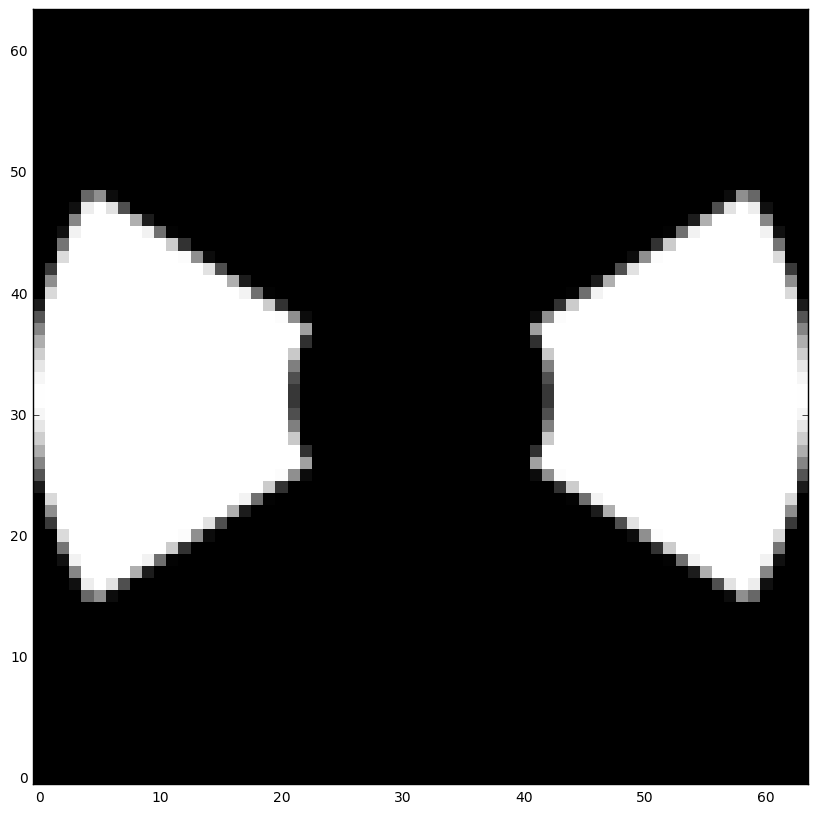

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(gray_FPM)

## Store the mask as FITS and ASCII arrays

In [9]:
FPM_quart_fits_fname = os.path.join(FPM_dir, "FPM_quart_diaphragm_{0:03d}R{1:03d}M{2:03d}_{3:s}{4:03d}deg.fits".format(
                                    int(10*R_0), int(10*R_1), M, openorient, openang))
FPM_quart_hdu = fits.PrimaryHDU(gray_FPM_quad)
FPM_quart_hdu.writeto(FPM_quart_fits_fname, clobber=True)
FPM_quart_dat_fname = FPM_quart_fits_fname[:-5] + ".dat"
np.savetxt(FPM_quart_dat_fname, gray_FPM_quad, fmt='%.6f', delimiter=" ")
print("Wrote FPM ASCII array to {0:s}".format(FPM_quart_dat_fname))
print("Wrote FPM FITS array to {0:s}".format(FPM_quart_fits_fname))

Wrote FPM ASCII array to /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/FPM/FPM_quart_diaphragm_108R320M032_H065deg.dat
Wrote FPM FITS array to /astro/opticslab1/SCDA/Apertures/InputMasks_WFIRST/FPM/FPM_quart_diaphragm_108R320M032_H065deg.fits
